# Smoothed Disperser transmission study for HD205905


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [147]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [148]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [149]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [150]:
from scipy import interpolate

In [151]:
import seaborn as sns

In [152]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [153]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [154]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [155]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../merra2'

In [156]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [157]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [158]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [159]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [160]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [161]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [162]:
home=os.getenv('HOME')

In [163]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [164]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [165]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [166]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [167]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [168]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [169]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [170]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

In [171]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [172]:
date="20170530"

In [173]:
idx_sel_subdir=2

In [174]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [175]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [176]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [177]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [178]:
wlshift.head()

,index,wlshift
0,57,-6.633933
1,58,-3.083037
2,60,-8.383797
3,61,-2.846134
4,62,-5.646836


### path for spectra

In [179]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [180]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [181]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [182]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [183]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits
2017-05-31T00:02:18.596,58,783,"9,3",26,"1,051","0,94",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_058.fits
2017-05-31T00:06:14.000,60,783,"9,1",26,"1,047","1,018",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_060.fits
2017-05-31T00:08:06.454,61,783,"9,2",26,"1,045","0,939",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_061.fits
2017-05-31T00:09:58.852,62,783,"9,1",26,"1,044","0,846",60,HD111980,dia,HoloPhP,12450,"5,8",data_30may17,reduc_20170530_062.fits


In [184]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T10:33:46.896,280,782,11,20,"1,018","0,793",60,HD205905,dia,Ron400,12400,"14,5",data_30may17,reduc_20170530_280.fits
2017-05-31T10:35:39.245,281,782,"11,2",20,"1,019","0,793",60,HD205905,dia,Thor300,12400,"13,1",data_30may17,reduc_20170530_281.fits
2017-05-31T10:37:31.598,282,782,11,20,"1,021","0,793",60,HD205905,dia,HoloPhP,12400,"12,5",data_30may17,reduc_20170530_282.fits
2017-05-31T10:39:24.046,283,782,11,20,"1,022","0,793",120,HD205905,dia,HoloPhAg,12400,"12,8",data_30may17,reduc_20170530_283.fits
2017-05-31T10:42:16.450,284,782,11,20,"1,024","0,793",120,HD205905,dia,HoloAmAg,12400,"13,2",data_30may17,reduc_20170530_284.fits


### Quick view on the kind of sources

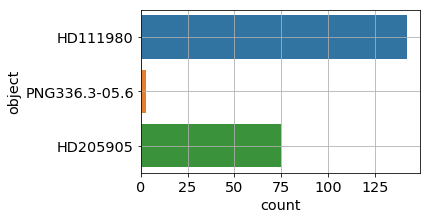

In [185]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

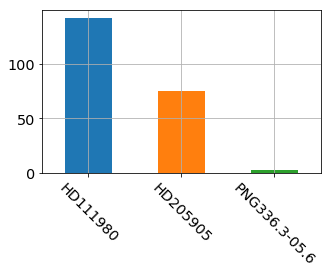

In [186]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [187]:
bad_obs_0=sel_obs.loc[sel_obs['index'].isin([57])]

In [188]:
bad_obs_0

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits


### Remove bad sources

- remove star **PNG336.3-05.6**

In [189]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD111980'])]
bad_indexes=bad_obs["index"]

In [190]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits
2017-05-31T00:02:18.596,58,783,"9,3",26,"1,051","0,94",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_058.fits
2017-05-31T00:06:14.000,60,783,"9,1",26,"1,047","1,018",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_060.fits
2017-05-31T00:08:06.454,61,783,"9,2",26,"1,045","0,939",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_061.fits
2017-05-31T00:09:58.852,62,783,"9,1",26,"1,044","0,846",60,HD111980,dia,HoloPhP,12450,"5,8",data_30may17,reduc_20170530_062.fits
2017-05-31T00:11:51.243,63,783,"8,9",26,"1,042","0,83",120,HD111980,dia,HoloPhAg,12450,"5,4",data_30may17,reduc_20170530_063.fits
2017-05-31T00:14:43.647,64,783,"8,9",26,"1,04","0,74",120,HD111980,dia,HoloAmAg,12450,"5,3",data_30may17,reduc_20170530_064.fits
2017-05-31T00:17:36.001,65,783,"8,8",26,"1,037","0,771",60,HD111980,dia,Ron400,12450,"5,4",data_30may17,reduc_20170530_065.fits
2017-05-31T00:19:28.503,66,783,"8,8",26,"1,036","0,715",60,HD111980,dia,Thor300,12450,"4,8",data_30may17,reduc_20170530_066.fits


In [191]:
bad_indexes=bad_obs.loc[:,"index"]

In [192]:
bad_indexes.index

Index([u'2017-05-31T00:00:26.147', u'2017-05-31T00:02:18.596',
       u'2017-05-31T00:06:14.000', u'2017-05-31T00:08:06.454',
       u'2017-05-31T00:09:58.852', u'2017-05-31T00:11:51.243',
       u'2017-05-31T00:14:43.647', u'2017-05-31T00:17:36.001',
       u'2017-05-31T00:19:28.503', u'2017-05-31T00:21:20.951',
       ...
       u'2017-05-31T05:07:24.403', u'2017-05-31T05:10:16.753',
       u'2017-05-31T05:13:09.206', u'2017-05-31T05:15:01.551',
       u'2017-05-31T05:16:53.954', u'2017-05-31T05:18:46.349',
       u'2017-05-31T05:21:38.803', u'2017-05-31T05:56:35.901',
       u'2017-05-31T06:05:21.701', u'2017-05-31T07:03:12.652'],
      dtype='object', name=u'date', length=145)

In [193]:
bad_indexes.values

array([ 57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 205])

### Concatenate bad obs

In [194]:
bad_obs=pd.concat([bad_obs,bad_obs_0])

In [195]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits
2017-05-31T00:02:18.596,58,783,"9,3",26,"1,051","0,94",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_058.fits
2017-05-31T00:06:14.000,60,783,"9,1",26,"1,047","1,018",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_060.fits
2017-05-31T00:08:06.454,61,783,"9,2",26,"1,045","0,939",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_061.fits
2017-05-31T00:09:58.852,62,783,"9,1",26,"1,044","0,846",60,HD111980,dia,HoloPhP,12450,"5,8",data_30may17,reduc_20170530_062.fits
2017-05-31T00:11:51.243,63,783,"8,9",26,"1,042","0,83",120,HD111980,dia,HoloPhAg,12450,"5,4",data_30may17,reduc_20170530_063.fits
2017-05-31T00:14:43.647,64,783,"8,9",26,"1,04","0,74",120,HD111980,dia,HoloAmAg,12450,"5,3",data_30may17,reduc_20170530_064.fits
2017-05-31T00:17:36.001,65,783,"8,8",26,"1,037","0,771",60,HD111980,dia,Ron400,12450,"5,4",data_30may17,reduc_20170530_065.fits
2017-05-31T00:19:28.503,66,783,"8,8",26,"1,036","0,715",60,HD111980,dia,Thor300,12450,"4,8",data_30may17,reduc_20170530_066.fits


In [196]:
bad_obs.sort_values(by="index",inplace=True)

In [197]:
bad_indexes=bad_obs.loc[:,"index"]

In [198]:
bad_indexes.index

Index([u'2017-05-31T00:00:26.147', u'2017-05-31T00:00:26.147',
       u'2017-05-31T00:02:18.596', u'2017-05-31T00:06:14.000',
       u'2017-05-31T00:08:06.454', u'2017-05-31T00:09:58.852',
       u'2017-05-31T00:11:51.243', u'2017-05-31T00:14:43.647',
       u'2017-05-31T00:17:36.001', u'2017-05-31T00:19:28.503',
       ...
       u'2017-05-31T05:07:24.403', u'2017-05-31T05:10:16.753',
       u'2017-05-31T05:13:09.206', u'2017-05-31T05:15:01.551',
       u'2017-05-31T05:16:53.954', u'2017-05-31T05:18:46.349',
       u'2017-05-31T05:21:38.803', u'2017-05-31T05:56:35.901',
       u'2017-05-31T06:05:21.701', u'2017-05-31T07:03:12.652'],
      dtype='object', name=u'date', length=146)

In [199]:
bad_indexes.values

array([ 57,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 205])

- keep stars **HD111980**, **HD205905**

In [200]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD205905'])]

In [201]:
sel2_obs=sel2_obs[sel2_obs.index !=57]      # REMOVE 57

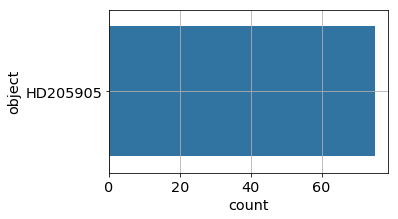

In [202]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [203]:
list_of_objects=sel2_obs['object'].values

In [204]:
list_of_objects=set(list_of_objects)

In [205]:
list_of_objects=list(list_of_objects)

In [206]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [207]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [208]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [209]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_060_spectrum.fits']

In [210]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [211]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_060_spectrum.fits']

In [212]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [213]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_060_spectrum.fits']

# Remove bad indexes

In [214]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170530_057_spectrum.fits
 remove  reduc_20170530_058_spectrum.fits
 remove  reduc_20170530_060_spectrum.fits
 remove  reduc_20170530_061_spectrum.fits
 remove  reduc_20170530_062_spectrum.fits
 remove  reduc_20170530_063_spectrum.fits
 remove  reduc_20170530_064_spectrum.fits
 remove  reduc_20170530_065_spectrum.fits
 remove  reduc_20170530_066_spectrum.fits
 remove  reduc_20170530_067_spectrum.fits
 remove  reduc_20170530_068_spectrum.fits
 remove  reduc_20170530_069_spectrum.fits
 remove  reduc_20170530_070_spectrum.fits
 remove  reduc_20170530_071_spectrum.fits
 remove  reduc_20170530_072_spectrum.fits
 remove  reduc_20170530_073_spectrum.fits
 remove  reduc_20170530_074_spectrum.fits
 remove  reduc_20170530_075_spectrum.fits
 remove  reduc_20170530_076_spectrum.fits
 remove  reduc_20170530_077_spectrum.fits
 remove  reduc_20170530_078_spectrum.fits
 remove  reduc_20170530_079_spectrum.fits
 remove  reduc_20170530_080_spectrum.fits
 remove  reduc_20170530_081_spectr

In [215]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_058_spectrum.fits
 remove  specsim_20170530_060_spectrum.fits
 remove  specsim_20170530_061_spectrum.fits
 remove  specsim_20170530_062_spectrum.fits
 remove  specsim_20170530_063_spectrum.fits
 remove  specsim_20170530_064_spectrum.fits
 remove  specsim_20170530_065_spectrum.fits
 remove  specsim_20170530_066_spectrum.fits
 remove  specsim_20170530_067_spectrum.fits
 remove  specsim_20170530_068_spectrum.fits
 remove  specsim_20170530_069_spectrum.fits
 remove  specsim_20170530_070_spectrum.fits
 remove  specsim_20170530_071_spectrum.fits
 remove  specsim_20170530_072_spectrum.fits
 remove  specsim_20170530_073_spectrum.fits
 remove  specsim_20170530_074_spectrum.fits
 remove  specsim_20170530_075_spectrum.fits
 remove  specsim_20170530_076_spectrum.fits
 remove  specsim_20170530_077_spectrum.fits
 remove  specsim_20170530_078_spectrum.fits
 remove  specsim_20170530_079_spectrum.fits
 remove  specsim_20170530_080_sp

In [216]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_058_spectrum.fits
 remove  specsim_20170530_060_spectrum.fits
 remove  specsim_20170530_061_spectrum.fits
 remove  specsim_20170530_062_spectrum.fits
 remove  specsim_20170530_063_spectrum.fits
 remove  specsim_20170530_064_spectrum.fits
 remove  specsim_20170530_065_spectrum.fits
 remove  specsim_20170530_066_spectrum.fits
 remove  specsim_20170530_067_spectrum.fits
 remove  specsim_20170530_068_spectrum.fits
 remove  specsim_20170530_069_spectrum.fits
 remove  specsim_20170530_070_spectrum.fits
 remove  specsim_20170530_071_spectrum.fits
 remove  specsim_20170530_072_spectrum.fits
 remove  specsim_20170530_073_spectrum.fits
 remove  specsim_20170530_074_spectrum.fits
 remove  specsim_20170530_075_spectrum.fits
 remove  specsim_20170530_076_spectrum.fits
 remove  specsim_20170530_077_spectrum.fits
 remove  specsim_20170530_078_spectrum.fits
 remove  specsim_20170530_079_spectrum.fits
 remove  specsim_20170530_080_sp

In [217]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_058_spectrum.fits
 remove  specsim_20170530_060_spectrum.fits
 remove  specsim_20170530_061_spectrum.fits
 remove  specsim_20170530_062_spectrum.fits
 remove  specsim_20170530_063_spectrum.fits
 remove  specsim_20170530_064_spectrum.fits
 remove  specsim_20170530_065_spectrum.fits
 remove  specsim_20170530_066_spectrum.fits
 remove  specsim_20170530_067_spectrum.fits
 remove  specsim_20170530_068_spectrum.fits
 remove  specsim_20170530_069_spectrum.fits
 remove  specsim_20170530_070_spectrum.fits
 remove  specsim_20170530_071_spectrum.fits
 remove  specsim_20170530_072_spectrum.fits
 remove  specsim_20170530_073_spectrum.fits
 remove  specsim_20170530_074_spectrum.fits
 remove  specsim_20170530_075_spectrum.fits
 remove  specsim_20170530_076_spectrum.fits
 remove  specsim_20170530_077_spectrum.fits
 remove  specsim_20170530_078_spectrum.fits
 remove  specsim_20170530_079_spectrum.fits
 remove  specsim_20170530_080_sp

# which filters

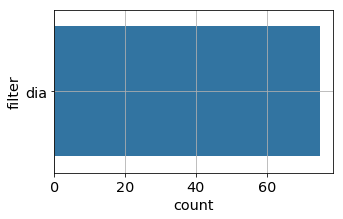

In [218]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

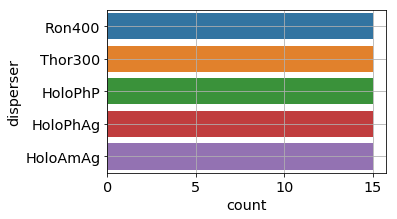

In [219]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [220]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [221]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [222]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [223]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [224]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

## Show the reconstructed spectra

In [225]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170530_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [226]:
thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

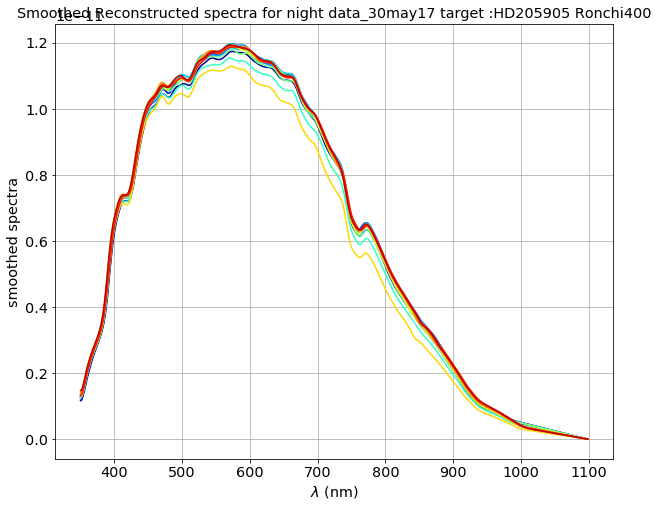

In [227]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### Thor 300

In [228]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

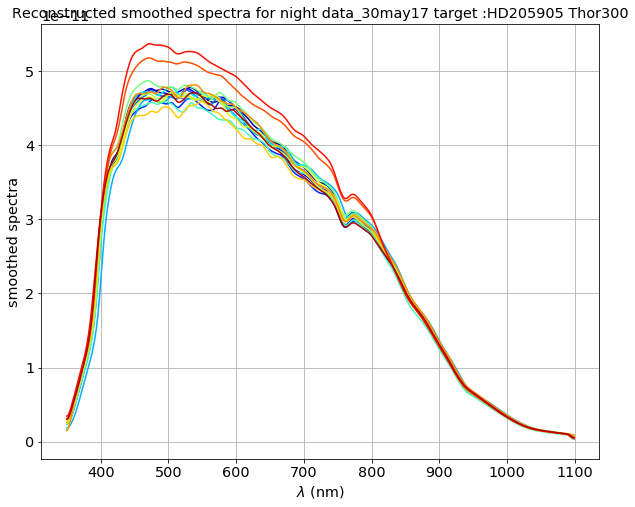

In [229]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhP

In [230]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

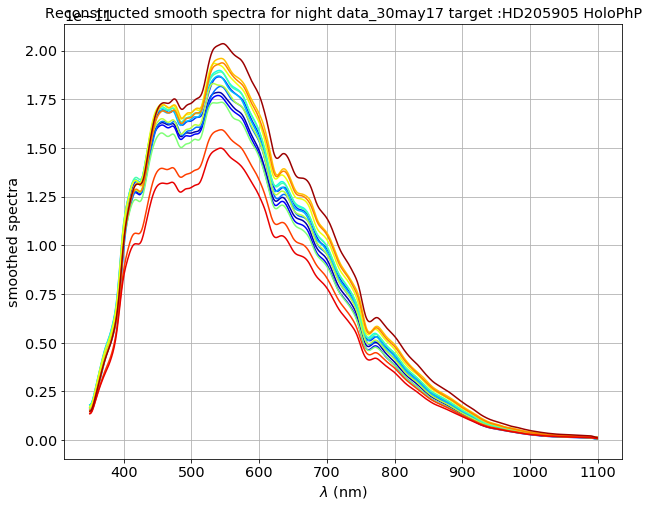

In [231]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhAg

In [232]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

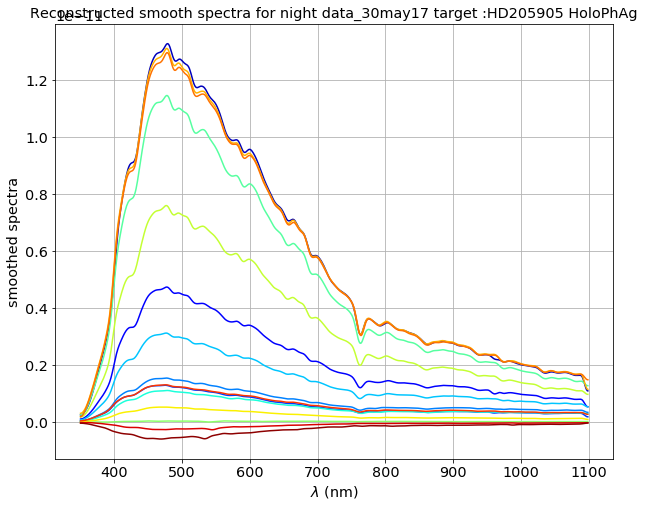

In [233]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloAmAg

In [234]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

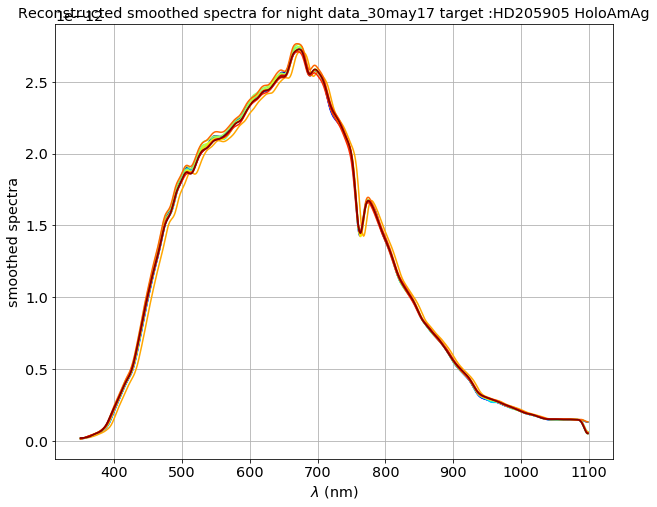

In [235]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Show the simulated spectra

In [236]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [237]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

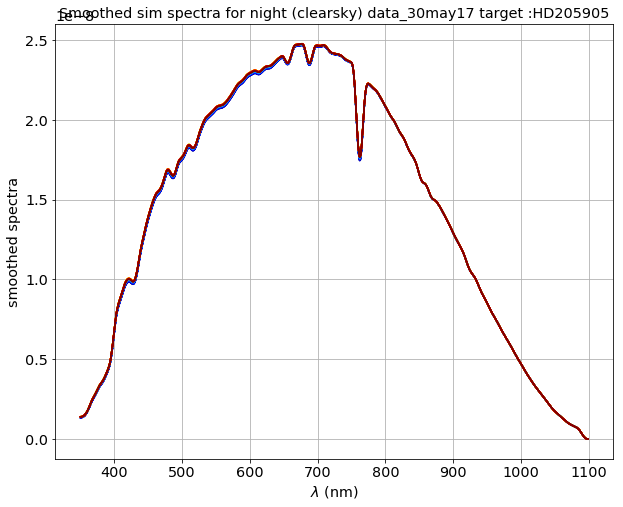

In [238]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### standard sky

In [239]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

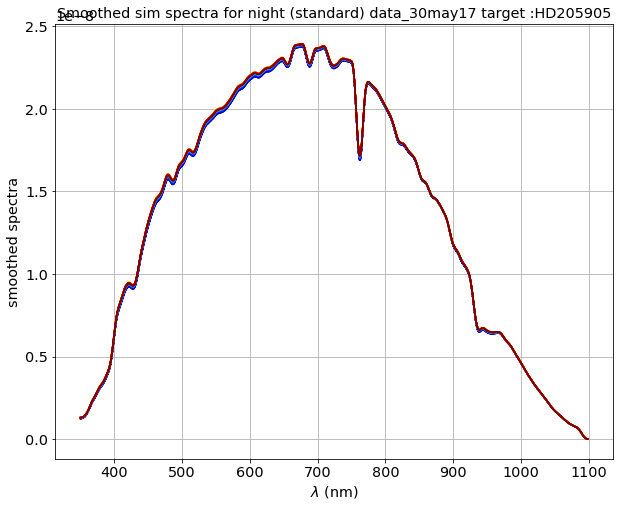

In [240]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### merra2 sky

In [241]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

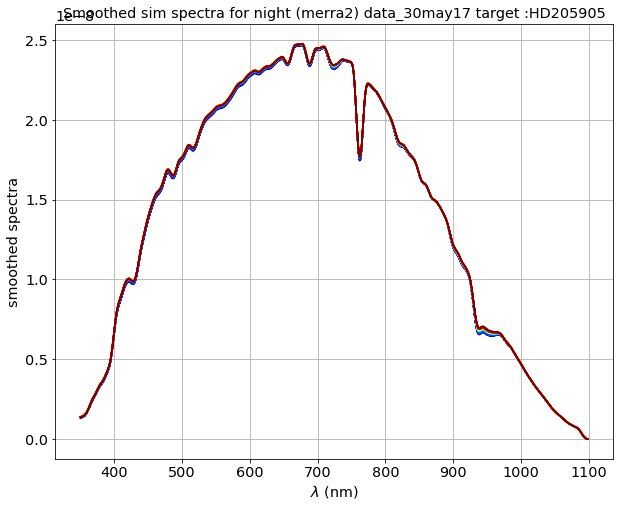

In [242]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

# Airmass vs Index

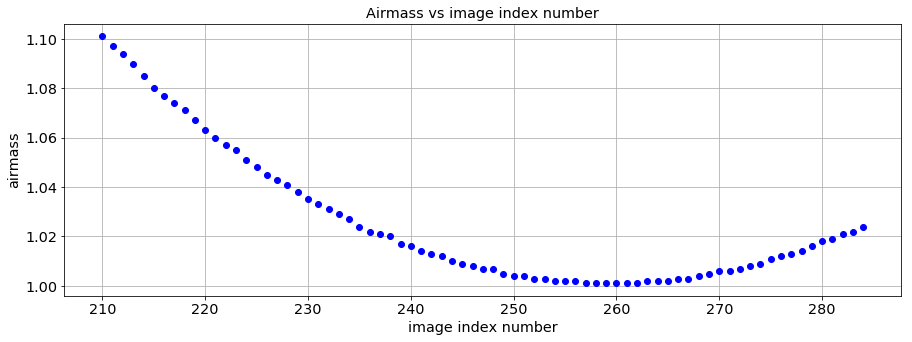

In [243]:
plt.figure(figsize=(15,5))
plt.plot(sel2_obs["index"],Convert_InFloat(sel2_obs["airmass"]),'bo')
plt.xlabel("image index number")
plt.ylabel("airmass")
plt.title('Airmass vs image index number')
plt.grid()

# Spectra ratio data/sim

In [244]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

## spectra ratio for Ronchi 400

In [245]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

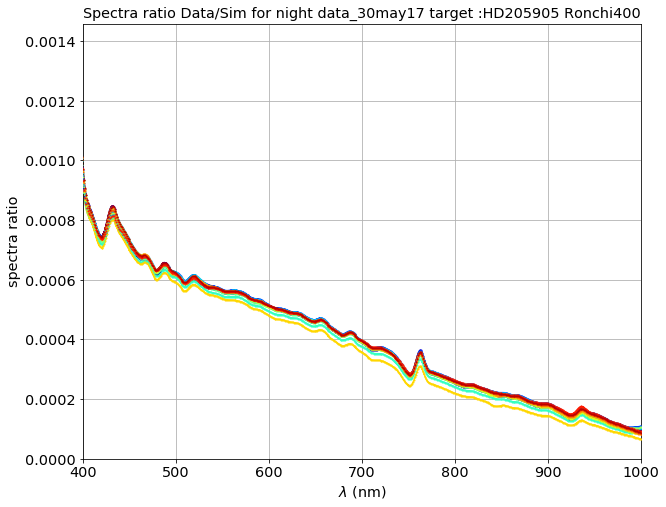

In [246]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 2.93795336814e-05 0.00291546094551


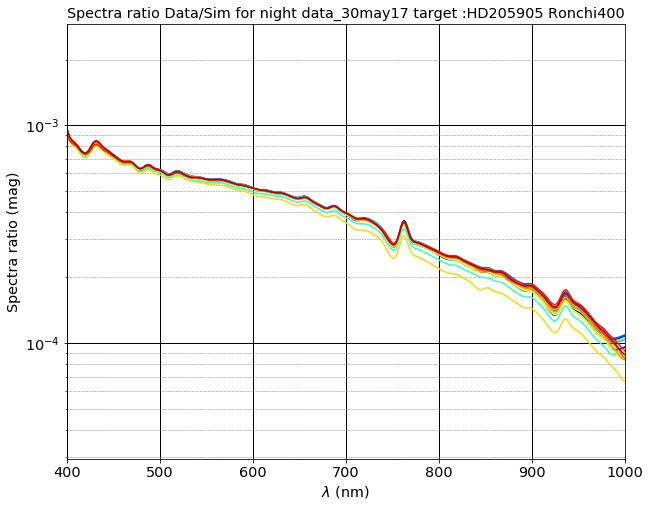

In [247]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [248]:
the_ratio_file="ratiosmooth_Ron400.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

In [249]:
#arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,"ratio_Ron400.fits",Flag_corr_wl=True)

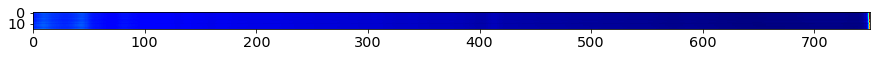

In [250]:
plt.imshow(arr[1:,:],cmap='jet')

## spectra ratio for Thor300

In [251]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

In [252]:
#PlotSpectraRatio(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,thetitle,Flag_corr_wl=True)

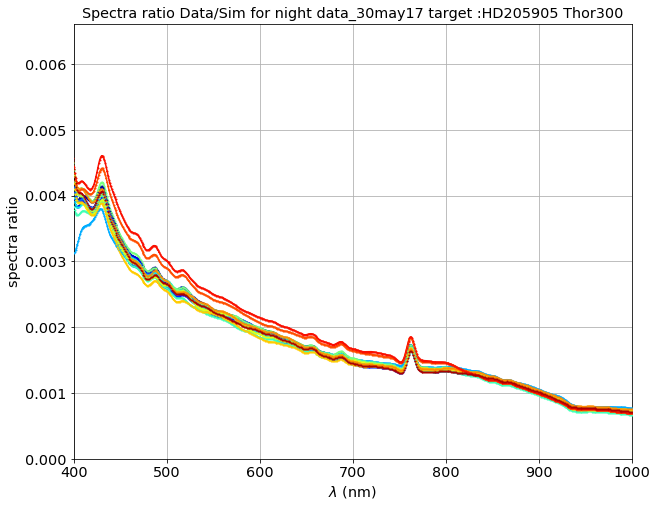

In [253]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 0.0002374687737 0.0132208008781


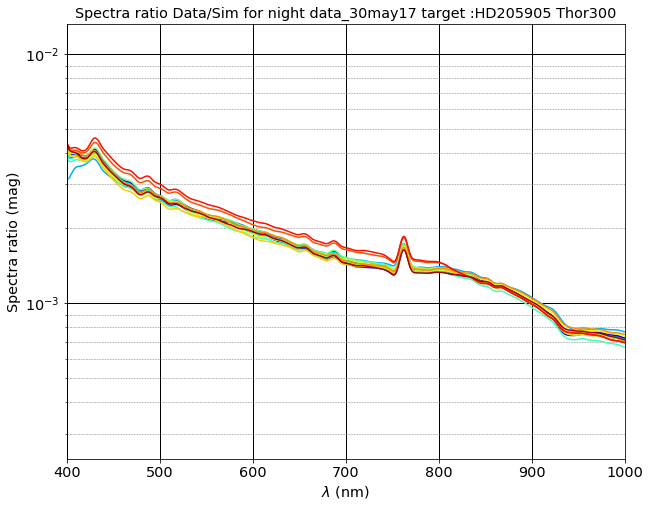

In [254]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [255]:
the_ratio_file="ratiosmooth_Thor300.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## spectra ratio for HoloPhP

In [256]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

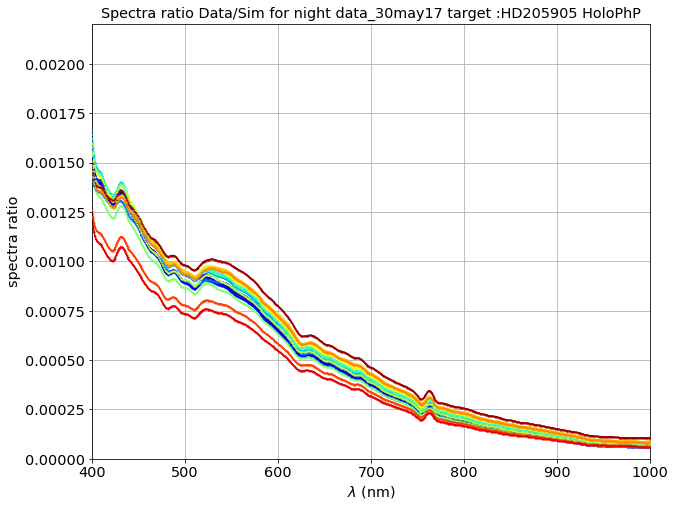

In [257]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 3.45492243019e-05 0.00440572623156


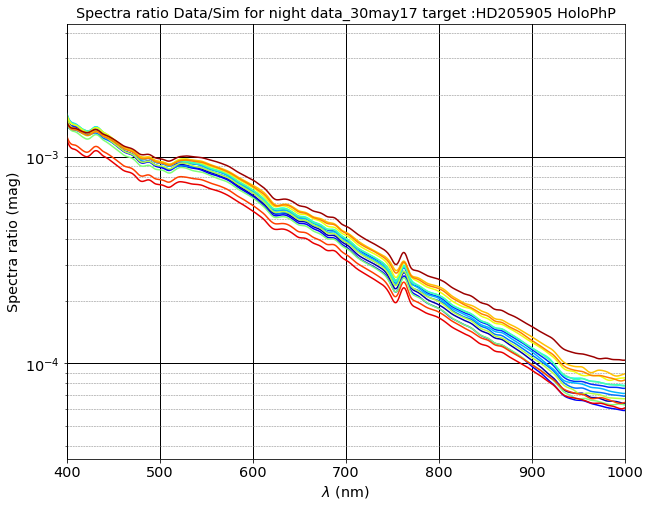

In [258]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [259]:
the_ratio_file="ratiosmooth_HoloPhP.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Spectrum ratio for HoloPhAg

In [260]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

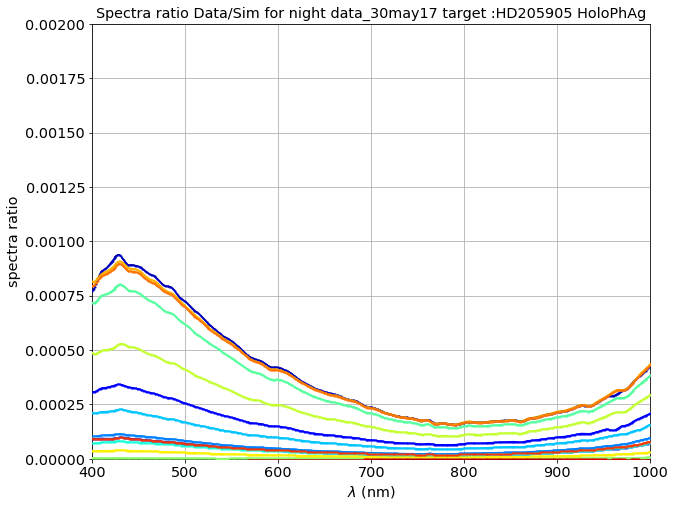

In [261]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0.002)

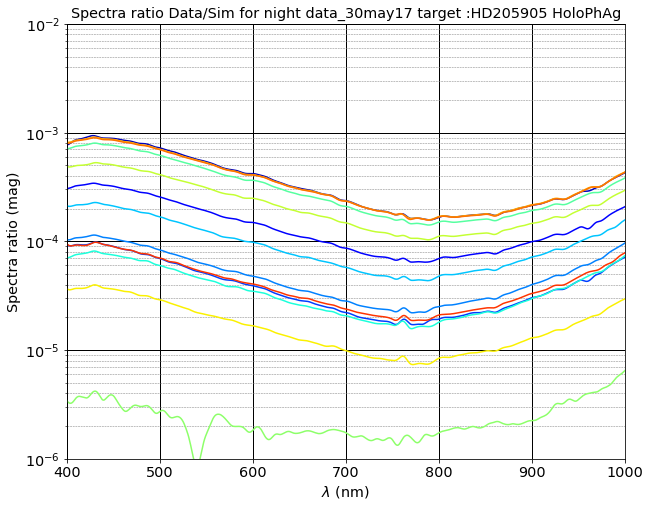

In [262]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=1e-6,YMAX=1e-2)

In [263]:
the_ratio_file="ratiosmooth_HoloPhAg.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)              

## Spectrum ratio for HoloAmAg

In [264]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

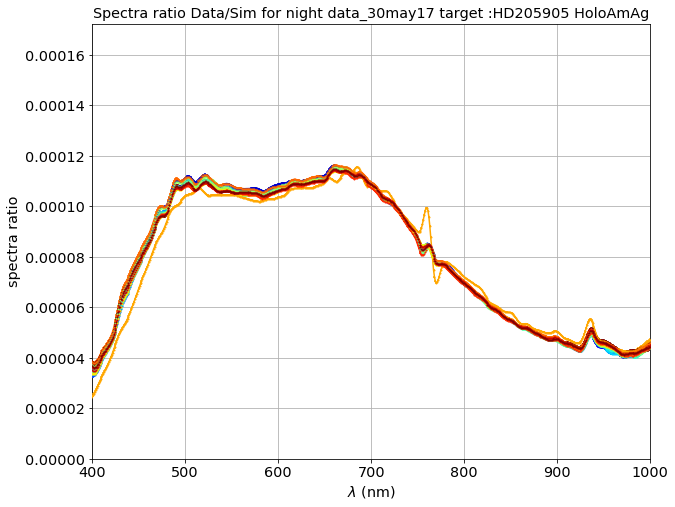

In [265]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim2,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 1.1288694162e-05 0.000332355899487


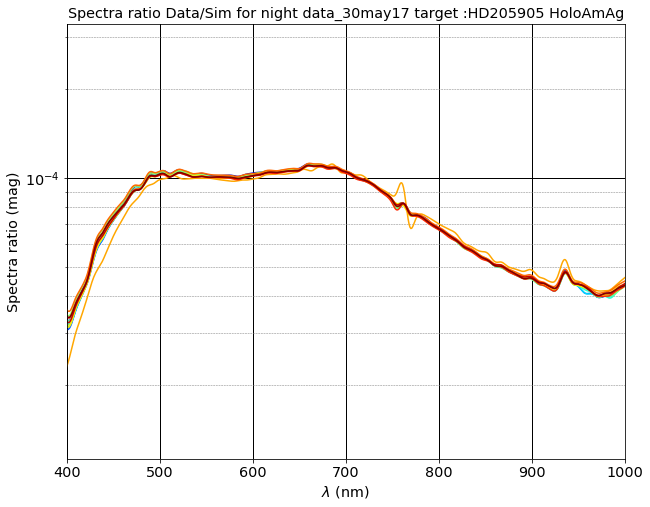

In [266]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [267]:
the_ratio_file="ratiosmooth_HoloAmAg.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloAmAg,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)    